# Uber Data Analysis to Predict Cab Fare

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import seaborn as sns

In [69]:
from sklearn.linear_model import LogisticRegression,LinearRegression

In [34]:
weather_data = pd.read_csv('weather.csv.csv')

In [12]:
cab_data = pd.read_csv('cab_rides.csv')

In [13]:
cab_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [10]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [14]:
cab_data = reduce_mem_usage(cab_data)

Memory usage of dataframe is 52.88 MB --> 44.95 MB (Decreased by 15.0%)


In [35]:
weather_data = reduce_mem_usage(weather_data)

Memory usage of dataframe is 0.38 MB --> 0.22 MB (Decreased by 43.7%)


In [16]:
cab_data = reduce_mem_usage(cab_data)

Memory usage of dataframe is 44.95 MB --> 44.95 MB (Decreased by 0.0%)


In [17]:
weather_data.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,8.0,24.299999,0.000000,3.4,6.3,NW,30.0,SW,NW,6.0,...,29,1019.700012,1015.000000,7,7,14.4,23.600000,No,3.600000,Yes
1,14.0,26.900000,3.600000,4.4,9.7,ENE,39.0,E,W,4.0,...,36,1012.400024,1008.400024,5,3,17.5,25.700001,Yes,3.600000,Yes
2,13.7,23.400000,3.600000,5.8,3.3,NW,85.0,N,NNE,6.0,...,69,1009.500000,1007.200012,8,7,15.4,20.200001,Yes,39.799999,Yes
3,13.3,15.500000,39.799999,7.2,9.1,NW,54.0,WNW,W,30.0,...,56,1005.500000,1007.000000,2,7,13.5,14.100000,Yes,2.800000,Yes
4,7.6,16.100000,2.800000,5.6,10.6,SSE,50.0,SSE,ESE,20.0,...,49,1018.299988,1018.500000,7,7,11.1,15.400000,Yes,0.000000,No


In [19]:
cab_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [20]:
cab_data.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name'],
      dtype='object')

In [36]:
weather_data.columns  # which returns the no of columns in the dataset

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'time_stamp',
       'humidity', 'wind'],
      dtype='object')

In [ ]:
# time stamp to datetime

In [22]:
import datetime

In [33]:
cab_data['datetime'] = pd.to_datetime(cab_data['time_stamp'])

In [32]:
cab_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,1970-01-01 00:25:44.952607890
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,1970-01-01 00:25:43.284023677
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,1970-01-01 00:25:43.366822198
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,1970-01-01 00:25:43.553582749
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,1970-01-01 00:25:43.463360223


In [37]:
weather_data['date_time'] = pd.to_datetime(weather_data['time_stamp'])

In [38]:
weather_data.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,date_time
0,42.419998,Back Bay,1.0,1012.140015,0.1228,1545003901,0.77,11.25,1970-01-01 00:00:01.545003901
1,42.430000,Beacon Hill,1.0,1012.150024,0.1846,1545003901,0.76,11.32,1970-01-01 00:00:01.545003901
2,42.500000,Boston University,1.0,1012.150024,0.1089,1545003901,0.76,11.07,1970-01-01 00:00:01.545003901
3,42.110001,Fenway,1.0,1012.130005,0.0969,1545003901,0.77,11.09,1970-01-01 00:00:01.545003901
4,43.130001,Financial District,1.0,1012.140015,0.1786,1545003901,0.75,11.49,1970-01-01 00:00:01.545003901


In [39]:
cab_data.shape

(693071, 11)

In [40]:
weather_data.shape

(6276, 9)

In [42]:
cab_data.describe()

,distance,time_stamp,price,surge_multiplier
count,693071.000000,6.930710e+05,637976.000000,693071.000000
mean,2.190057,1.544046e+12,16.543797,1.013870
std,1.138935,6.891925e+08,9.319172,0.091467
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.280000,1.543444e+12,9.000000,1.000000
50%,2.160000,1.543737e+12,13.500000,1.000000
75%,2.920000,1.544828e+12,22.500000,1.000000
max,7.860000,1.545161e+12,97.500000,3.000000


In [43]:
weather_data.describe()

,temp,clouds,pressure,rain,time_stamp,humidity,wind
count,6276.000000,6276.000000,6276.000000,894.000000,6.276000e+03,6276.000000,6276.000000
mean,39.090378,0.677775,1008.443176,0.057652,1.543857e+09,0.763976,6.802810
std,6.022061,0.314283,12.870790,0.100758,6.659340e+05,0.127340,3.633476
min,19.620001,0.000000,988.250000,0.000200,1.543204e+09,0.450000,0.290000
25%,36.077501,0.440000,997.747498,0.004900,1.543387e+09,0.670000,3.517500
50%,40.130001,0.780000,1007.659973,0.014850,1.543514e+09,0.760000,6.570000
75%,42.832501,0.970000,1018.479980,0.060925,1.544691e+09,0.890000,9.920000
max,55.410000,1.000000,1035.119995,0.780700,1.545159e+09,0.990000,18.180000


In [ ]:
# concat data

In [56]:
a = pd.concat([cab_data,weather_data])

C:\Users\BHUBESH\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [57]:
a.head()# mix of weather and cab data 

,cab_type,clouds,date_time,datetime,destination,distance,humidity,id,location,name,pressure,price,product_id,rain,source,surge_multiplier,temp,time_stamp,wind
0,Lyft,NaN,NaT,1970-01-01 00:25:44.952607890,North Station,0.44,NaN,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,NaN,Shared,NaN,5.0,lyft_line,NaN,Haymarket Square,1.0,NaN,1544952607890,NaN
1,Lyft,NaN,NaT,1970-01-01 00:25:43.284023677,North Station,0.44,NaN,4bd23055-6827-41c6-b23b-3c491f24e74d,NaN,Lux,NaN,11.0,lyft_premier,NaN,Haymarket Square,1.0,NaN,1543284023677,NaN
2,Lyft,NaN,NaT,1970-01-01 00:25:43.366822198,North Station,0.44,NaN,981a3613-77af-4620-a42a-0c0866077d1e,NaN,Lyft,NaN,7.0,lyft,NaN,Haymarket Square,1.0,NaN,1543366822198,NaN
3,Lyft,NaN,NaT,1970-01-01 00:25:43.553582749,North Station,0.44,NaN,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,NaN,Lux Black XL,NaN,26.0,lyft_luxsuv,NaN,Haymarket Square,1.0,NaN,1543553582749,NaN
4,Lyft,NaN,NaT,1970-01-01 00:25:43.463360223,North Station,0.44,NaN,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,NaN,Lyft XL,NaN,9.0,lyft_plus,NaN,Haymarket Square,1.0,NaN,1543463360223,NaN


In [58]:
a['day'] = a.date_time.dt.day

In [59]:
a['hour'] = a.date_time.dt.hour

In [60]:
a.tail()

,cab_type,clouds,date_time,datetime,destination,distance,humidity,id,location,name,...,price,product_id,rain,source,surge_multiplier,temp,time_stamp,wind,day,hour
6271,NaN,0.89,1970-01-01 00:00:01.543819974,NaT,NaN,NaN,0.96,NaN,North Station,NaN,...,NaN,NaN,NaN,NaN,NaN,44.720001,1543819974,1.52,1.0,0.0
6272,NaN,0.88,1970-01-01 00:00:01.543819974,NaT,NaN,NaN,0.96,NaN,Northeastern University,NaN,...,NaN,NaN,NaN,NaN,NaN,44.849998,1543819974,1.54,1.0,0.0
6273,NaN,0.89,1970-01-01 00:00:01.543819974,NaT,NaN,NaN,0.96,NaN,South Station,NaN,...,NaN,NaN,NaN,NaN,NaN,44.820000,1543819974,1.54,1.0,0.0
6274,NaN,0.89,1970-01-01 00:00:01.543819974,NaT,NaN,NaN,0.96,NaN,Theatre District,NaN,...,NaN,NaN,NaN,NaN,NaN,44.779999,1543819974,1.54,1.0,0.0
6275,NaN,0.89,1970-01-01 00:00:01.543819974,NaT,NaN,NaN,0.96,NaN,West End,NaN,...,NaN,NaN,NaN,NaN,NaN,44.689999,1543819974,1.52,1.0,0.0


In [62]:
# NaN values
a.fillna(0 , inplace = True)

In [63]:
a.head()  # just we filled the NaN values with 0

,cab_type,clouds,date_time,datetime,destination,distance,humidity,id,location,name,...,price,product_id,rain,source,surge_multiplier,temp,time_stamp,wind,day,hour
0,Lyft,0.0,0,1970-01-01 00:25:44.952607890,North Station,0.44,0.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,0,Shared,...,5.0,lyft_line,0.0,Haymarket Square,1.0,0.0,1544952607890,0.0,0.0,0.0
1,Lyft,0.0,0,1970-01-01 00:25:43.284023677,North Station,0.44,0.0,4bd23055-6827-41c6-b23b-3c491f24e74d,0,Lux,...,11.0,lyft_premier,0.0,Haymarket Square,1.0,0.0,1543284023677,0.0,0.0,0.0
2,Lyft,0.0,0,1970-01-01 00:25:43.366822198,North Station,0.44,0.0,981a3613-77af-4620-a42a-0c0866077d1e,0,Lyft,...,7.0,lyft,0.0,Haymarket Square,1.0,0.0,1543366822198,0.0,0.0,0.0
3,Lyft,0.0,0,1970-01-01 00:25:43.553582749,North Station,0.44,0.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,0,Lux Black XL,...,26.0,lyft_luxsuv,0.0,Haymarket Square,1.0,0.0,1543553582749,0.0,0.0,0.0
4,Lyft,0.0,0,1970-01-01 00:25:43.463360223,North Station,0.44,0.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,0,Lyft XL,...,9.0,lyft_plus,0.0,Haymarket Square,1.0,0.0,1543463360223,0.0,0.0,0.0


In [64]:
a.columns # after concatination

Index(['cab_type', 'clouds', 'date_time', 'datetime', 'destination',
       'distance', 'humidity', 'id', 'location', 'name', 'pressure', 'price',
       'product_id', 'rain', 'source', 'surge_multiplier', 'temp',
       'time_stamp', 'wind', 'day', 'hour'],
      dtype='object')

In [65]:
a.groupby('cab_type').count()

,clouds,date_time,datetime,destination,distance,humidity,id,location,name,pressure,price,product_id,rain,source,surge_multiplier,temp,time_stamp,wind,day,hour
cab_type,,,,,,,,,,,,,,,,,,,,
0,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276
Lyft,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408
Uber,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663


In [ ]:
# what is groupby function?

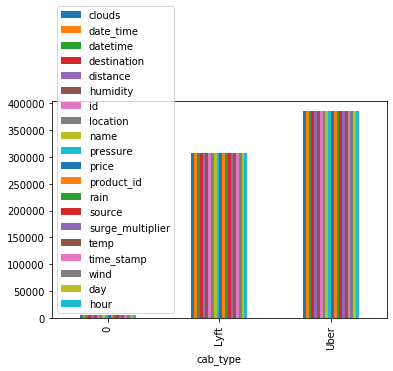

In [70]:
a.groupby('cab_type').count().plot.bar()

In [ ]:
# what is count()
#count() function in an inbuilt function in python programming language that returns the number of occurrences of a substring in the given string.

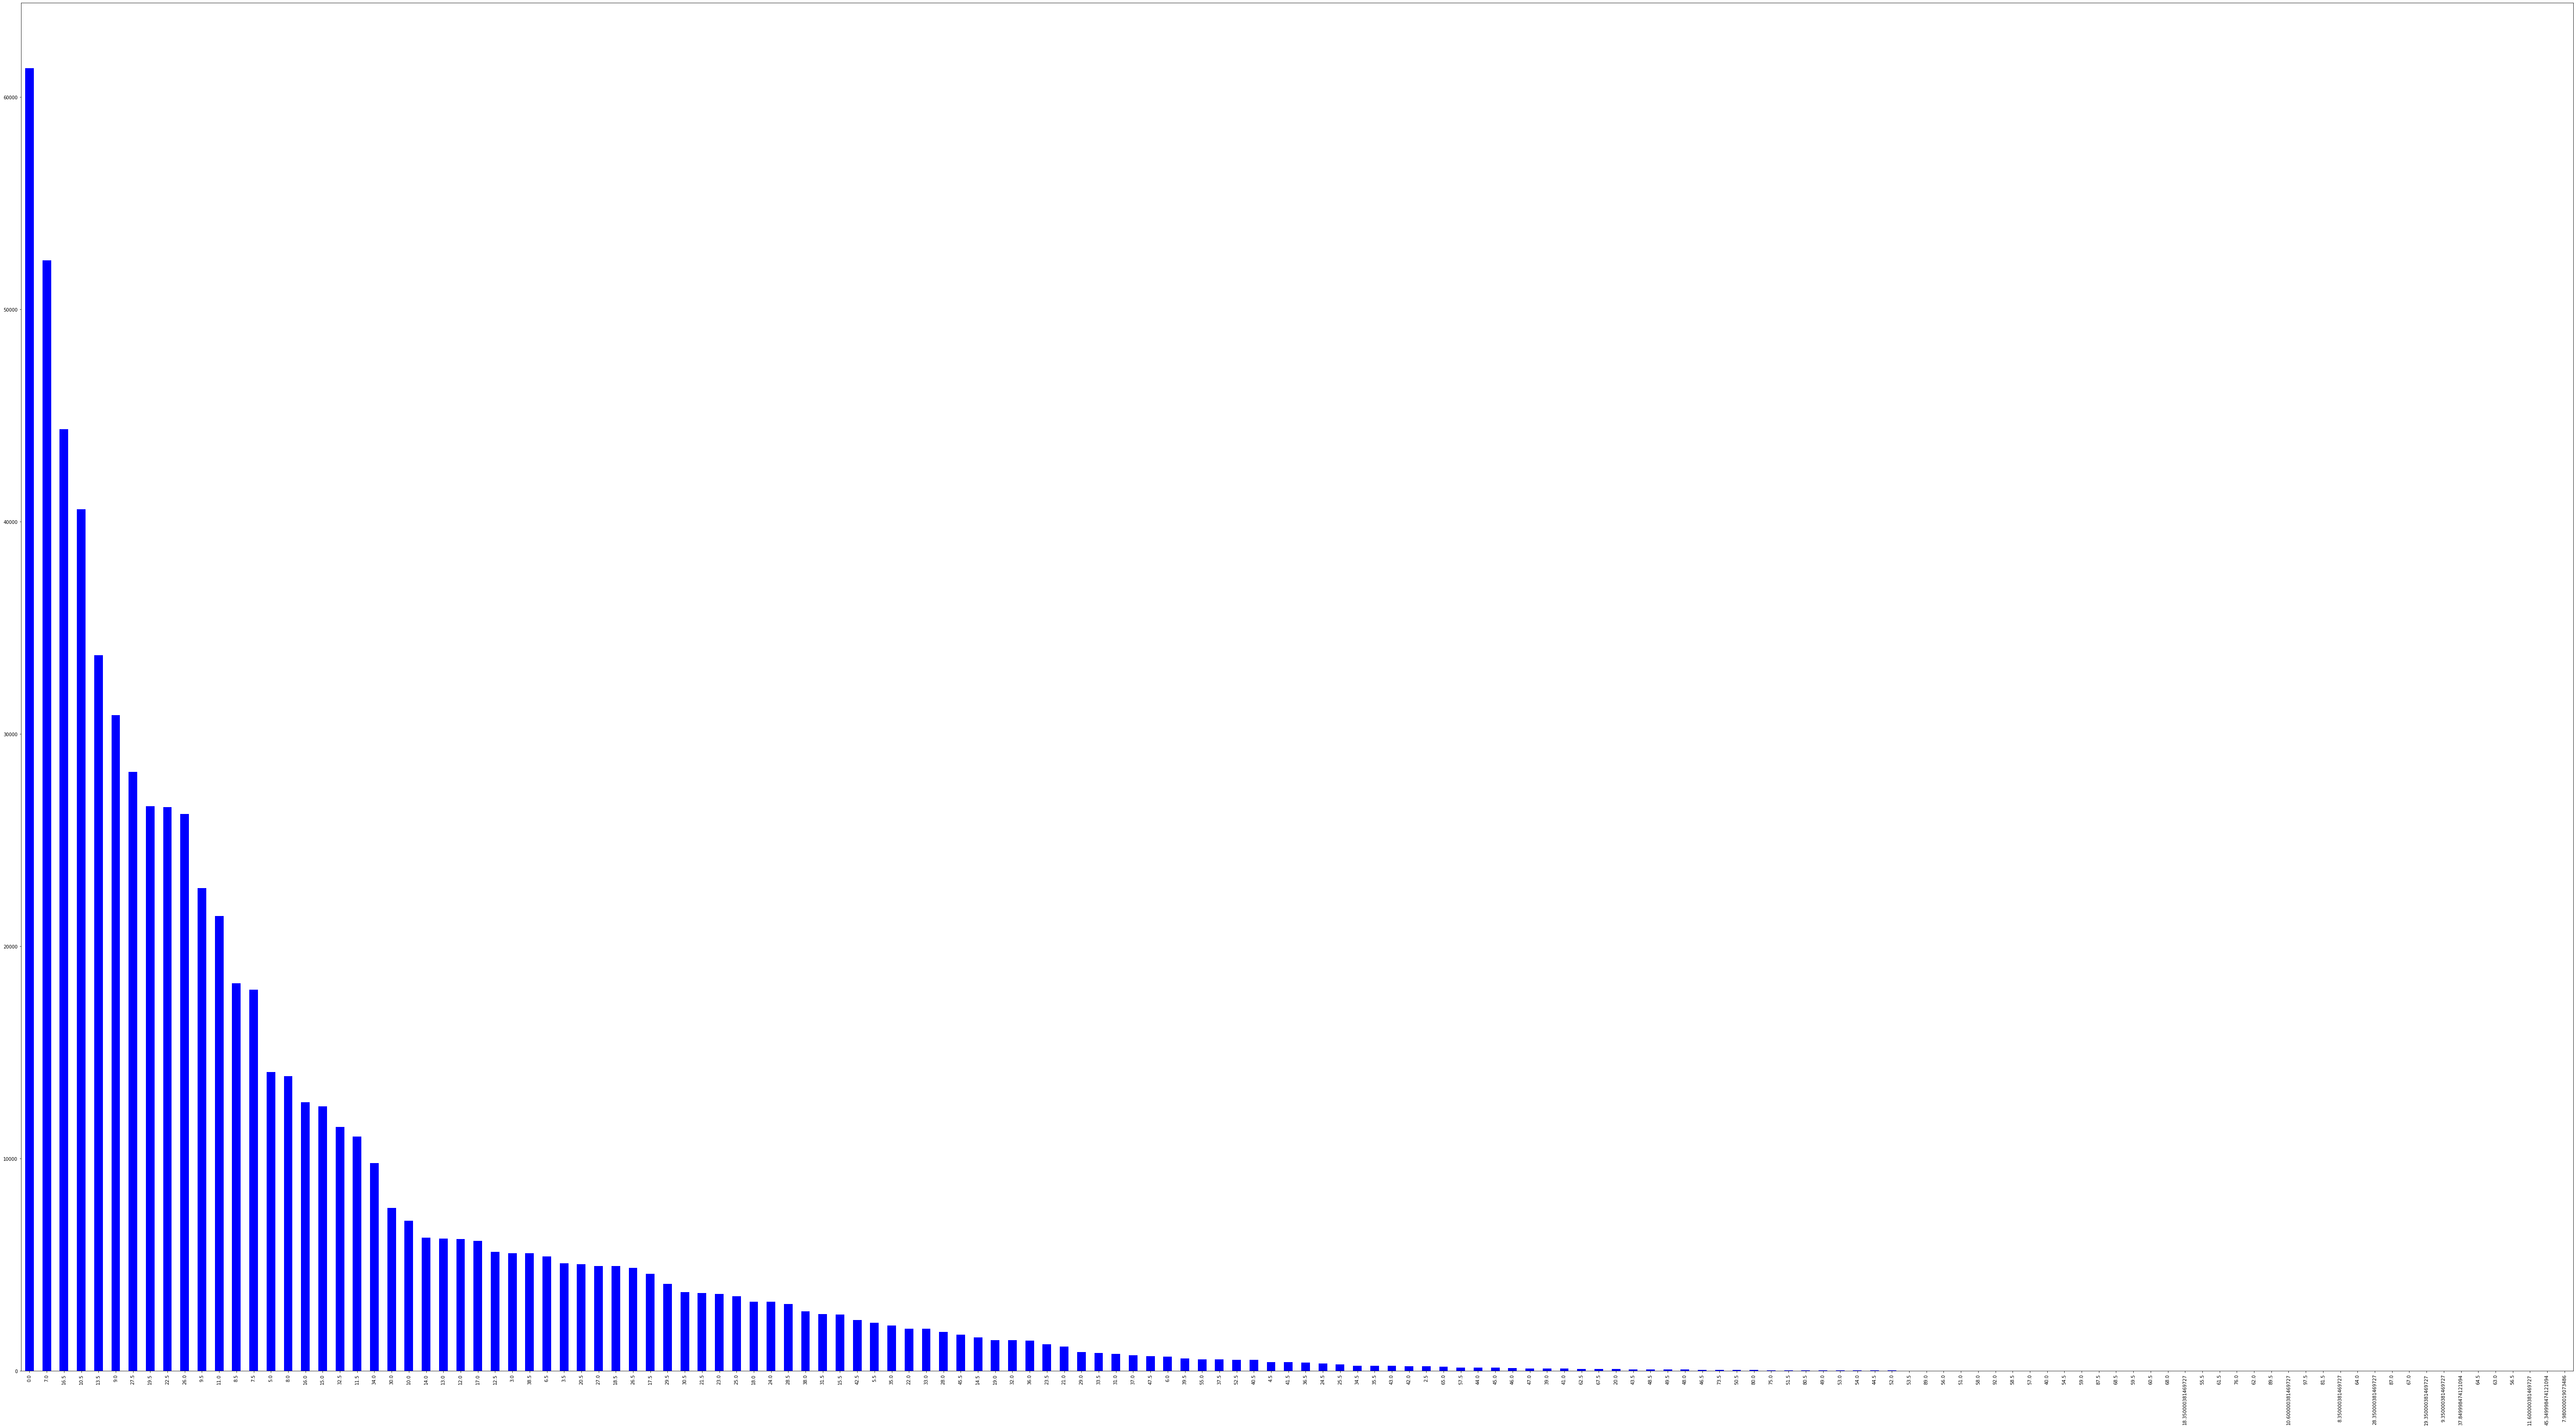

In [72]:
# price 
a['price'].value_counts().plot(kind = 'bar' , figsize =(100,55),color = 'blue')

In [ ]:
# peak hour for the cab


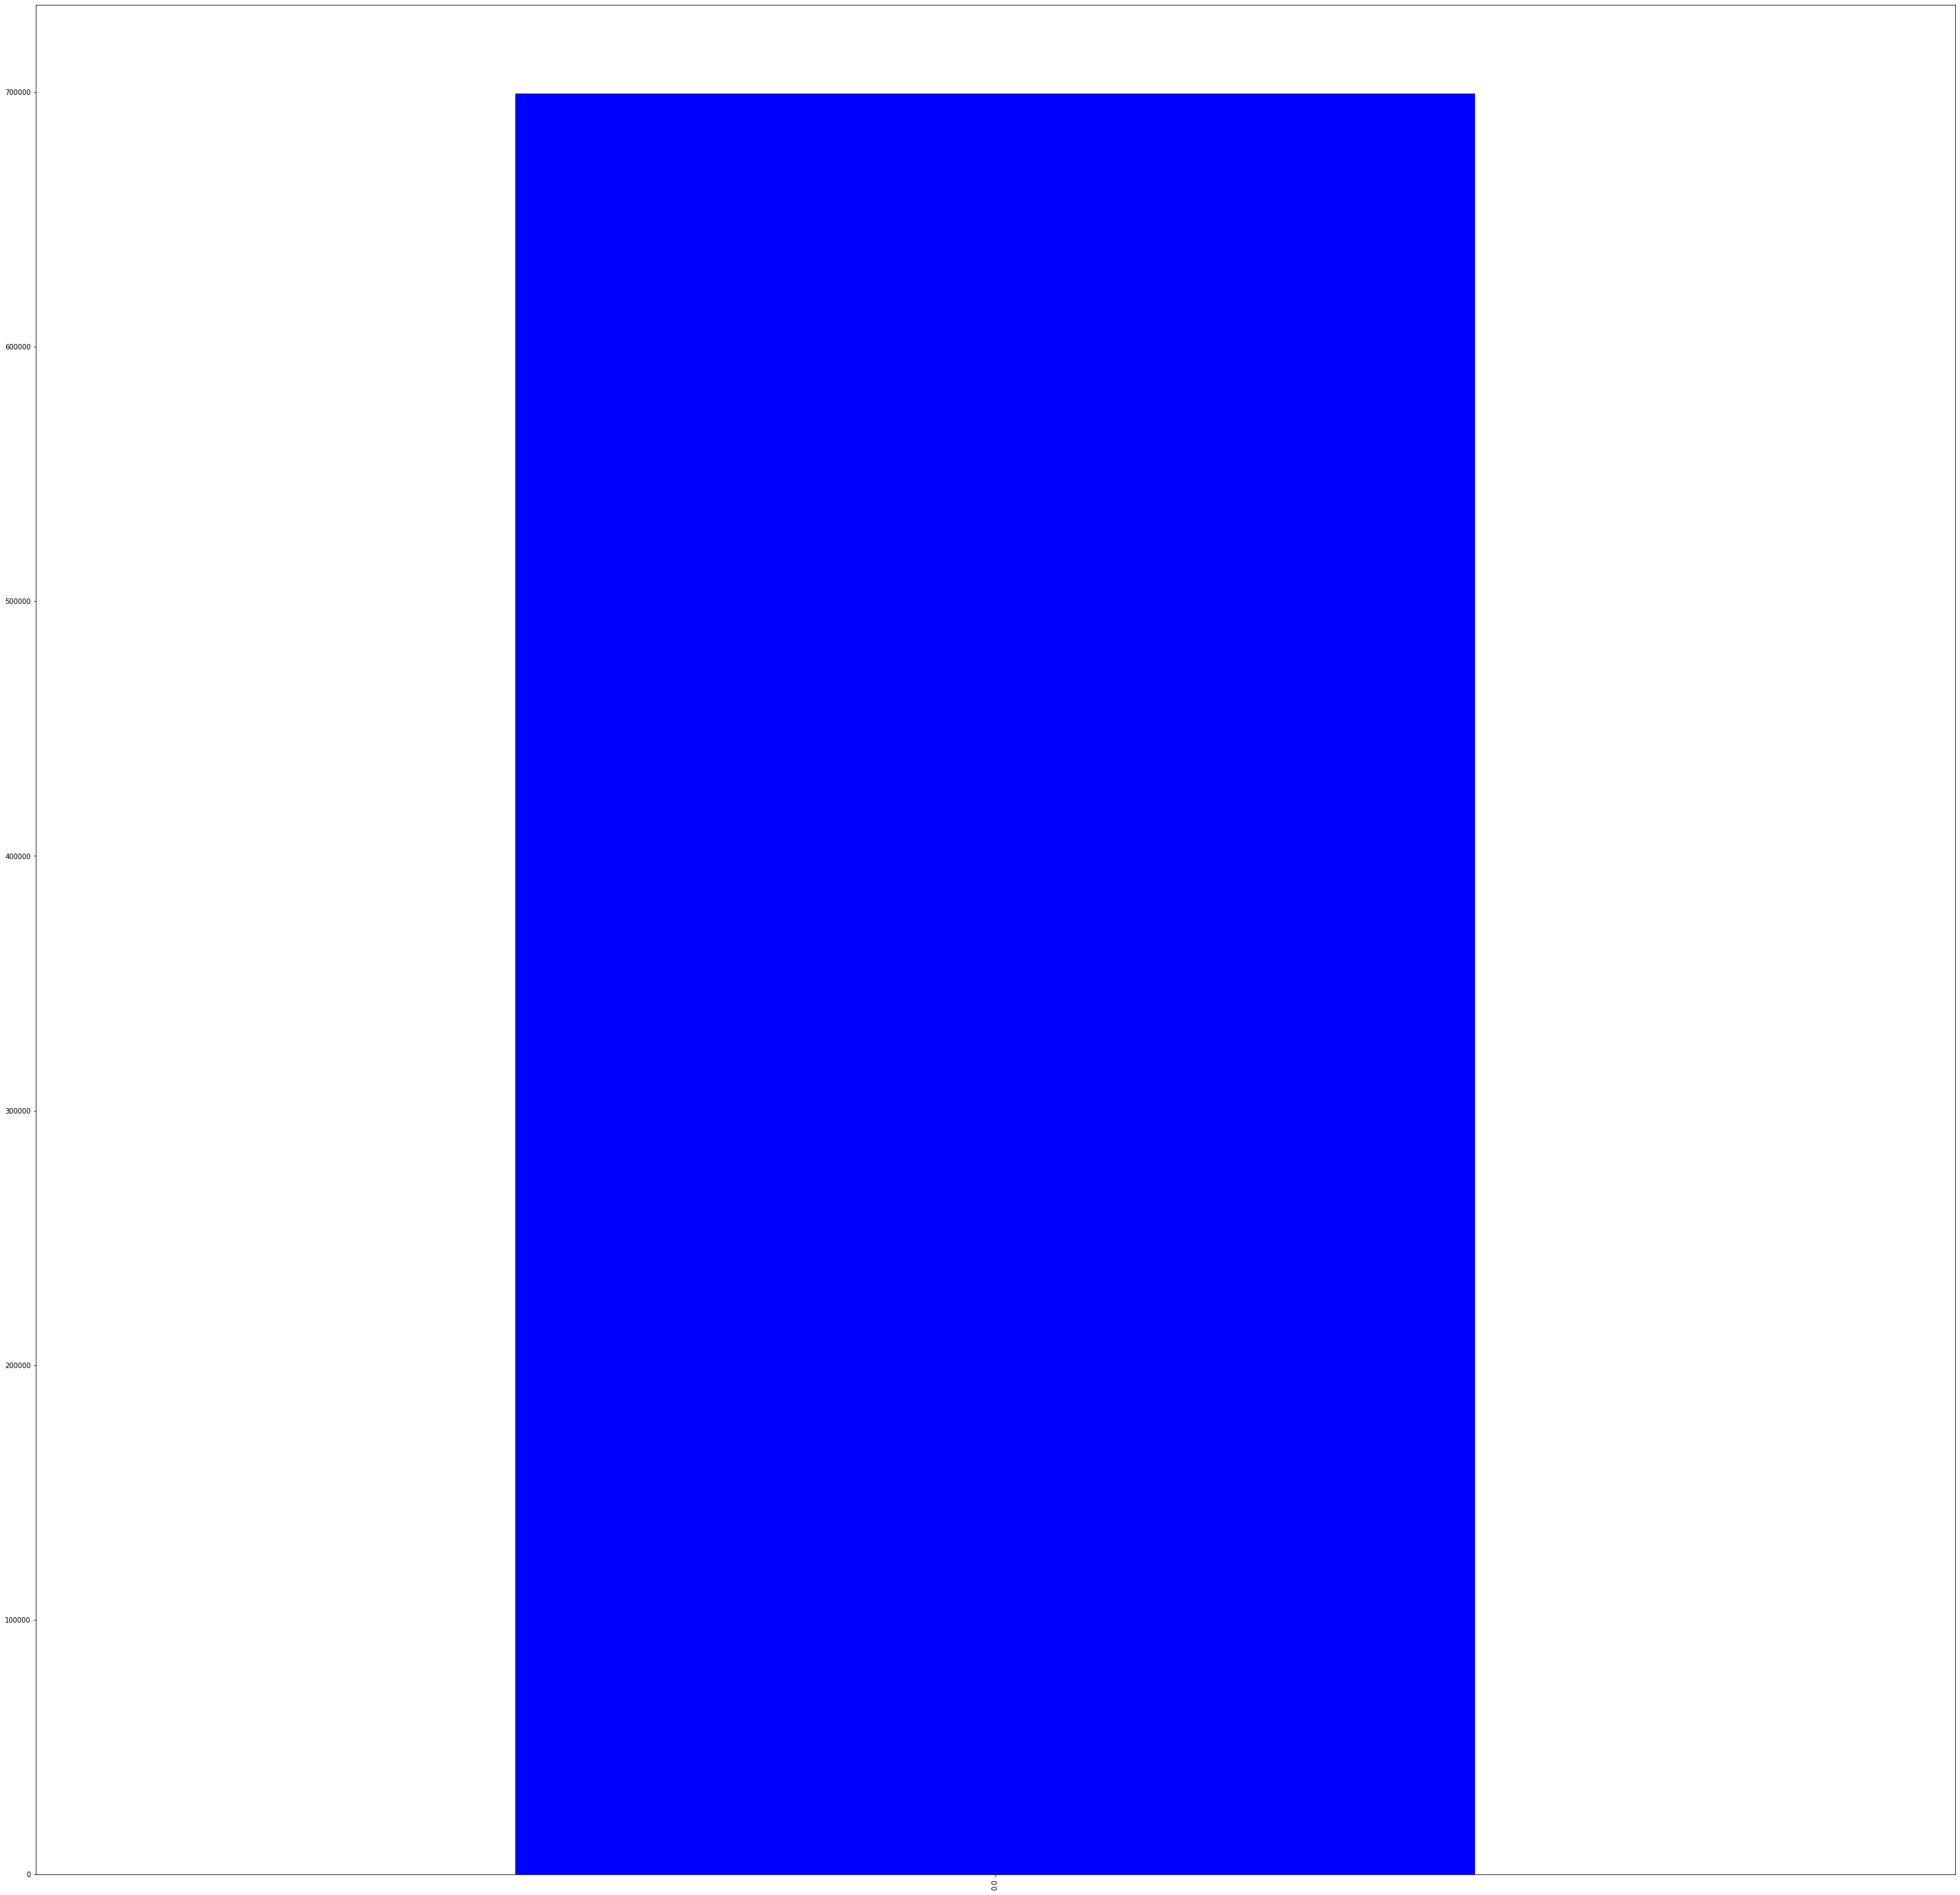

In [76]:
a['hour'].value_counts().plot(kind = 'bar' , figsize =(50,50),color = 'blue')

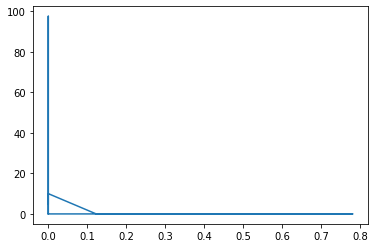

In [77]:
x =a['rain']
y = a['price']
plt.plot(x,y)
plt.show()


In [ ]:
# making the model


In [78]:
x1=a[['distance', 'temp','clouds', 'pressure', 'humidity','wind','rain','day','hour','surge_multiplier','clouds']]
y1=a['price']

In [ ]:
# using skicit-learn to split data into trining part to testing part

In [79]:
from sklearn.model_selection import train_test_split

In [ ]:
# split the data into the training and testing data

In [81]:
x_train , y_train , x_test ,y_test = train_test_split(x1,y1 , test_size =0.50 , random_state = 50)

In [82]:
lr = LinearRegression()

In [83]:
lr.fit(x_train , x_test)

LinearRegression()

In [85]:
predictions = lr.predict(y_train)
predictions

array([11.99542922, 12.7077787 , 13.14027635, ..., 23.08772444,
       16.54937612, 17.31260795])

In [87]:
# compare the actual and the predicted one
df = pd.DataFrame({'Actual': y_test , 'predicted' : predictions})

In [88]:
df

,Actual,predicted
73049,26.0,1.199543e+01
185026,27.5,1.270778e+01
609443,13.0,1.314028e+01
35129,30.0,1.542997e+01
641715,19.5,1.688011e+01
630009,5.0,1.268234e+01
21868,0.0,1.207175e+01
668288,15.0,1.522644e+01
324688,13.5,1.202087e+01
551230,5.0,1.044353e+01


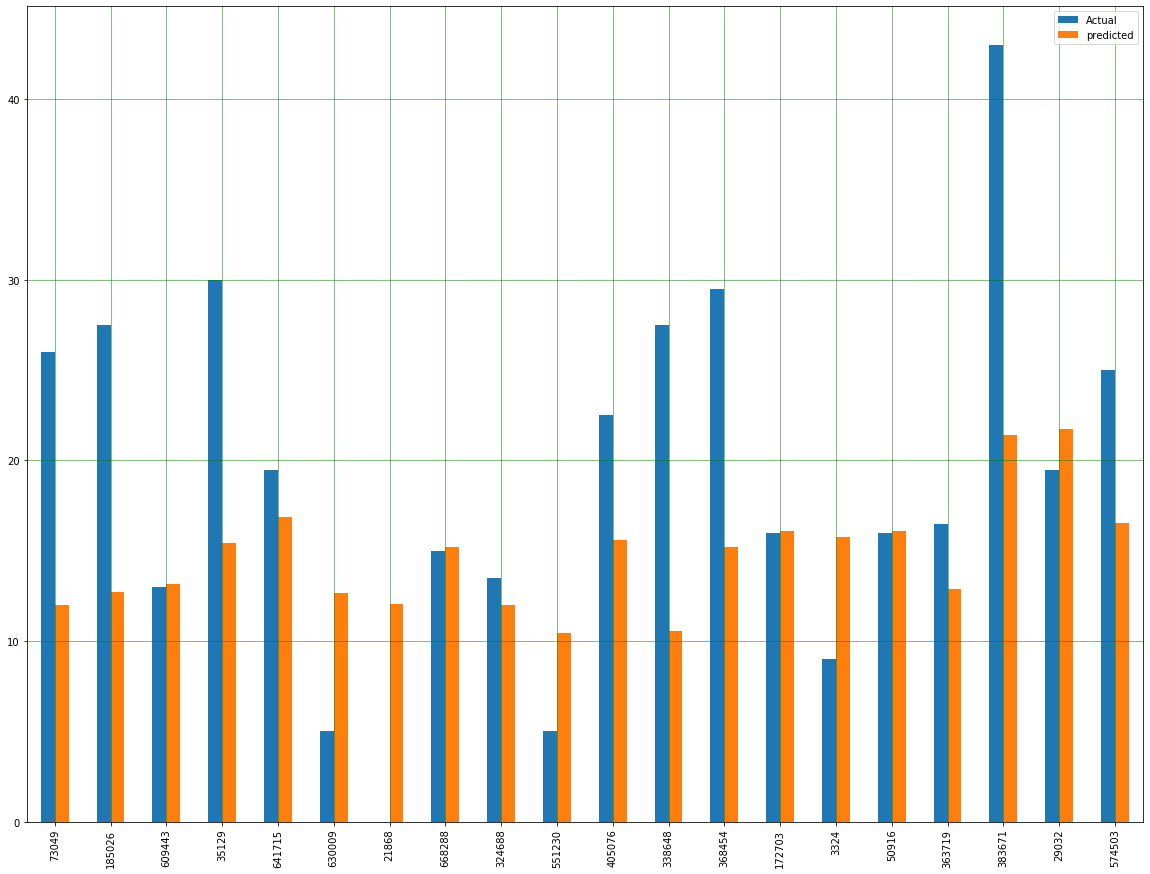

In [90]:
df1 = df.head(20)
df1.plot(kind = 'bar' , figsize=(20,15))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Thanks to Great Learning